# Homework 04: Building CNNs for Image Classification

## Due: Midnight on September 28 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects. 

There are 10 graded questions, worth 8 points each, with 5 points free if you complete the homework. 


## 1. Setup and Data Loading


In [2]:
!pip install kagglehub

In [3]:
!pip install --upgrade pip

In [4]:
!pip install tensorflow

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-28 23:30:35.506863: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-28 23:30:37.199875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-28 23:30:40.459760: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [6]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [7]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default 
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,                  
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),      
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  



In [8]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

In [9]:
# Reproducible load + preprocess for Intel Image Classification
# -------------------------
# Loader (deterministic)
# -------------------------
def load_data_from_directory(directory, img_size=(150, 150), class_names=None):
    """
    Loads images as float32 in [0,1] and integer labels.
    Sorting ensures deterministic order. If class_names is provided,
    that ordering defines label indices.
    Returns: X, y, class_names_used
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # Ensure only classes present in directory are used (robustness)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        # Sort filenames so load order is reproducible
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            # Explicit interpolation for consistency
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img)  # float32
            X.append(arr)
            y.append(class_to_idx[class_name])
    X = (np.array(X, dtype="float32") / 255.0)   # normalize to [0,1]
    y = np.array(y, dtype="int32")               # integer labels
    return X, y, class_names
def show_counts(name, y_arr):
    c = Counter(y_arr.tolist() if hasattr(y_arr, "tolist") else y_arr)
    print(f"{name} per-class counts:", dict(c))
# -------------------------
# Download & paths
# -------------------------
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")
# -------------------------
# Load train (get class_names) & test using same mapping
# -------------------------
X_train_all, y_train_all, class_names = load_data_from_directory(train_dir, img_size=(75,75))
X_test, y_test, *_ = load_data_from_directory(test_dir, img_size=(75,75), class_names=class_names)
num_classes = len(class_names)
print("class_names:", class_names)
print("X_train_all:", X_train_all.shape, "y_train_all:", y_train_all.shape)
print("X_test:     ", X_test.shape,      "y_test:     ", y_test.shape)
# -------------------------
# Stratified train/val split (reproducible)
# -------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True
)

class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train_all: (14034, 75, 75, 3) y_train_all: (14034,)
X_test:      (3000, 75, 75, 3) y_test:      (3000,)


### Examine The Dataset

In [10]:
print("X_train:",  X_train.shape,  "y_train:",  y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

X_train: (11227, 75, 75, 3) y_train: (11227,)
X_val: (2807, 75, 75, 3) y_val: (2807,)
train per-class counts: {0: 1753, 4: 1819, 2: 1923, 1: 1817, 5: 1906, 3: 2009}
val   per-class counts: {1: 454, 2: 481, 3: 503, 0: 438, 4: 455, 5: 476}
test  per-class counts: {0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


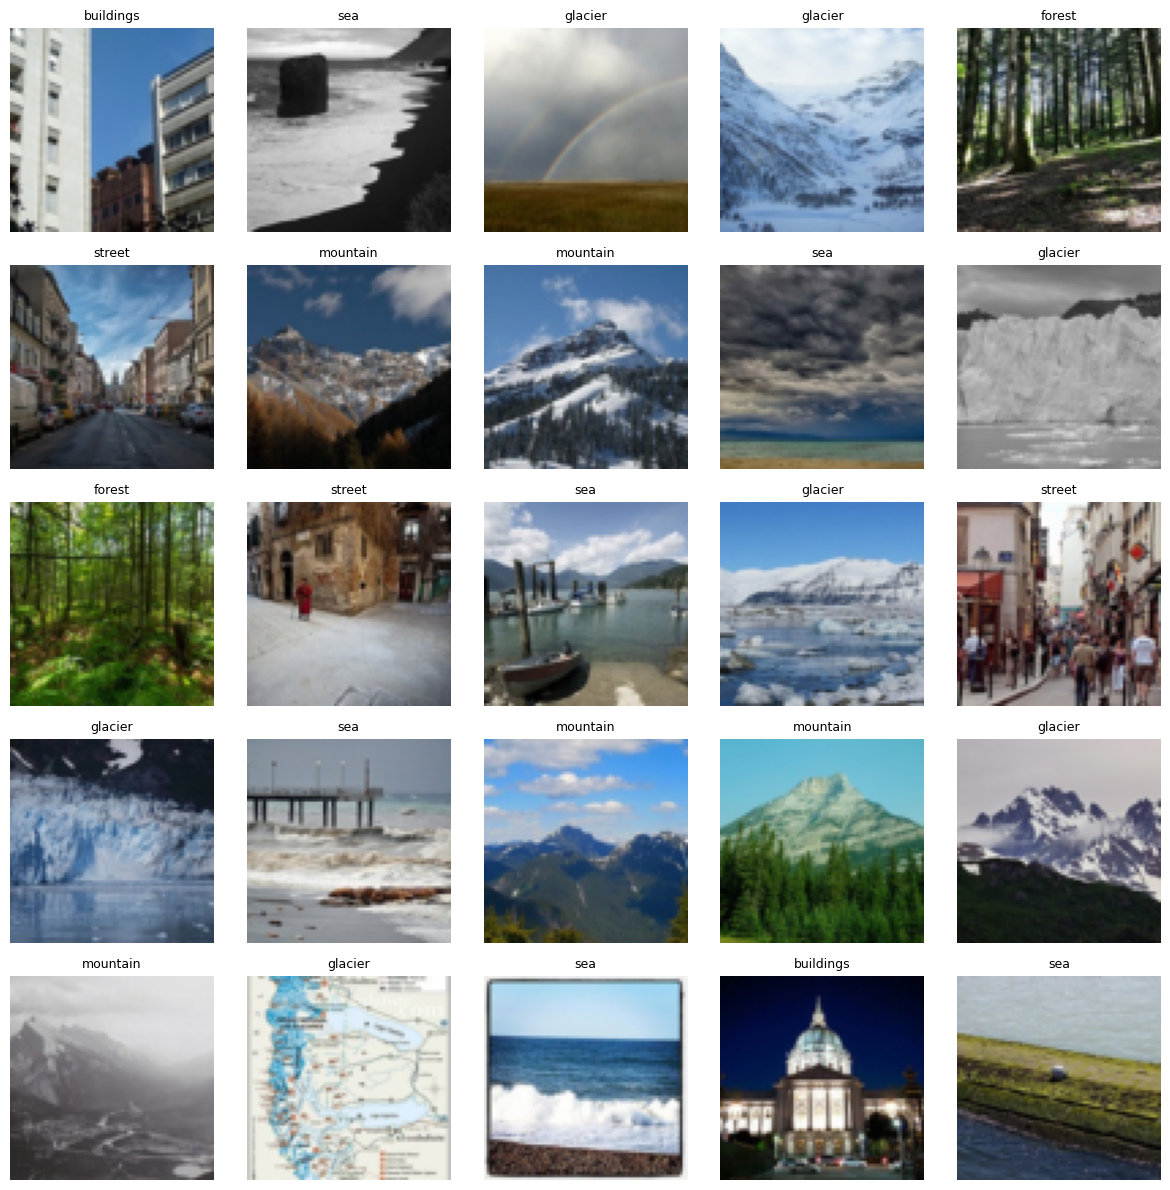

In [11]:
# Show a 5×5 grid of the first 25 training images
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[i])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!). 

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in. 


In [12]:
# Force TensorFlow to use CPU only
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Also set TensorFlow to use CPU explicitly
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

print("Available devices:", tf.config.list_physical_devices())
print("TensorFlow will use CPU only")

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow will use CPU only


2025-09-28 23:30:59.756393: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Attempting conservative baseline...
Model parameters: 337094
Training with 2000 samples, validating with 500 samples
Epoch 1/10


2025-09-28 23:31:00.101112: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 135000000 exceeds 10% of free system memory.


  5/125 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1690 - loss: 2.9990

2025-09-28 23:31:01.736508: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26021952 exceeds 10% of free system memory.
2025-09-28 23:31:01.779518: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26021952 exceeds 10% of free system memory.
2025-09-28 23:31:01.818208: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26021952 exceeds 10% of free system memory.
2025-09-28 23:31:01.855746: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26021952 exceeds 10% of free system memory.


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.2720 - loss: 1.6974 - val_accuracy: 0.4200 - val_loss: 1.3824
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4145 - loss: 1.3802 - val_accuracy: 0.5380 - val_loss: 1.1858
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4440 - loss: 1.2755 - val_accuracy: 0.5620 - val_loss: 1.0961
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4745 - loss: 1.2302 - val_accuracy: 0.5820 - val_loss: 1.1139
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5185 - loss: 1.1268 - val_accuracy: 0.5940 - val_loss: 1.0465
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5260 - loss: 1.1130 - val_accuracy: 0.5980 - val_loss: 1.0463
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5595 - loss: 1.0204 - val_accuracy: 0.6260 - val_loss: 0.9946
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5750 - loss: 0.9915 - val_accuracy: 0.57

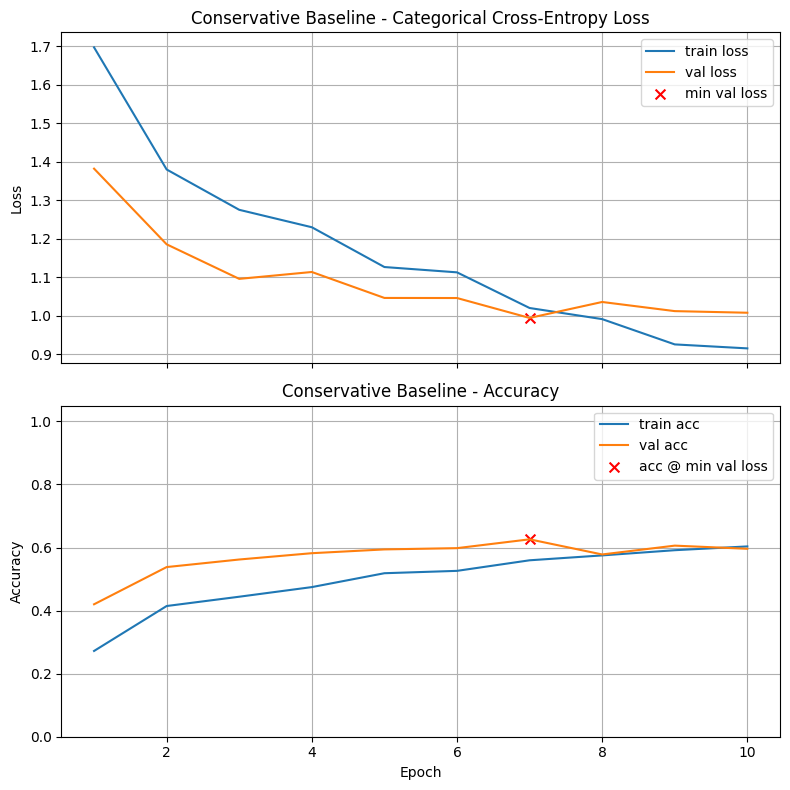

Final Training Loss:            0.9155
Final Training Accuracy:        0.6035
Final Validation Loss:          1.0081
Final Validation Accuracy:      0.5960
Minimum Validation Loss:        0.9946 (Epoch 7)
Validation Accuracy @ Min Loss: 0.6260


In [13]:
# Try a more realistic baseline with memory constraints
print("Attempting conservative baseline...")

he = initializers.HeNormal()
model_conservative = models.Sequential([
    Input(shape=(75, 75, 3)),
    Conv2D(16, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # 16 instead of 32
    MaxPooling2D(2),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # 32 instead of 64
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu", kernel_initializer=he),  # 32 instead of 64
    Dropout(0.3),  # Lower dropout
    Dense(6, activation="softmax")
])

model_conservative.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(f"Model parameters: {model_conservative.count_params()}")

# Use more data but still conservative
X_small_train = X_train[:2000]  # 2000 training samples
y_small_train = y_train[:2000]
X_small_val = X_val[:500]       # 500 validation samples
y_small_val = y_val[:500]

print(f"Training with {X_small_train.shape[0]} samples, validating with {X_small_val.shape[0]} samples")

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

try:
    history = model_conservative.fit(
        X_small_train, y_small_train,
        validation_data=(X_small_val, y_small_val),
        epochs=10,
        batch_size=16,  # Small batch size
        callbacks=[early_stop],
        verbose=1
    )
    
    # Plot results
    plot_learning_curves(history, "Conservative Baseline")
    
except Exception as e:
    print(f"Training failed: {e}")

Using 2000 training samples and 500 validation samples

Baseline Model (Memory-Limited)



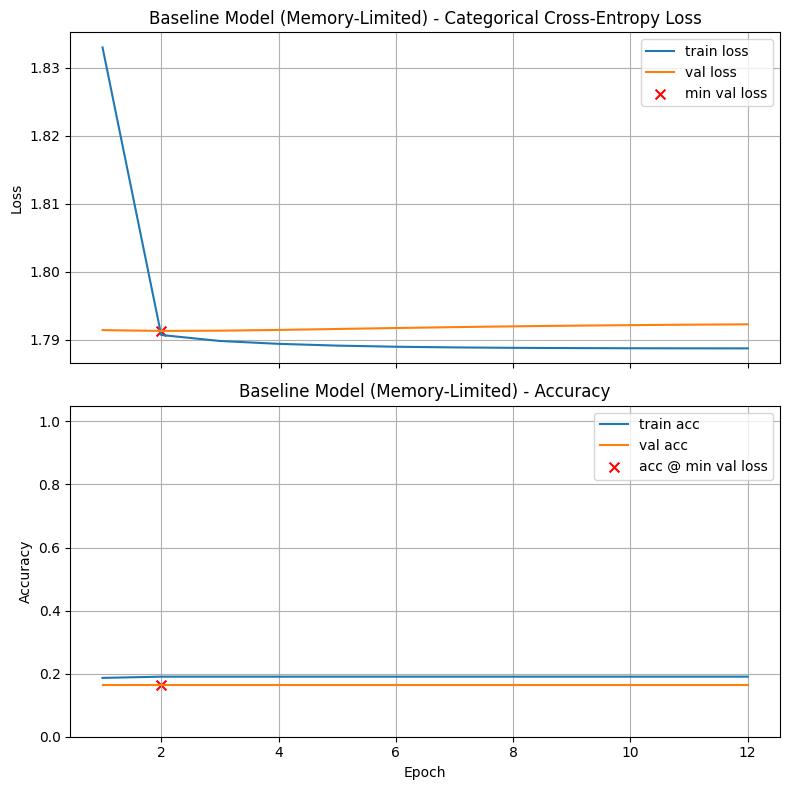

Final Training Loss:            1.7887
Final Training Accuracy:        0.1905
Final Validation Loss:          1.7922
Final Validation Accuracy:      0.1640
Minimum Validation Loss:        1.7913 (Epoch 2)
Validation Accuracy @ Min Loss: 0.1640

Test Loss: 1.7917
Test Accuracy: 0.1670

Validation-Test Gap (accuracy): 0.003000

Execution Time: 00:01:06


In [14]:
he = initializers.HeNormal()
model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(16, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Use subset of data to prevent memory crash
X_train_subset = X_train[:2000]
y_train_subset = y_train[:2000]
X_val_subset = X_val[:500]
y_val_subset = y_val[:500]

print(f"Using {len(X_train_subset)} training samples and {len(X_val_subset)} validation samples")

# Temporarily override global variables for this training
X_train_orig = X_train
y_train_orig = y_train
X_val_orig = X_val
y_val_orig = y_val

X_train = X_train_subset
y_train = y_train_subset
X_val = X_val_subset
y_val = y_val_subset

train_and_test(model_baseline, 
               title="Baseline Model (Memory-Limited)",
               batch_size=16,
               epochs=20)

# Restore original variables
X_train = X_train_orig
y_train = y_train_orig
X_val = X_val_orig
y_val = y_val_orig

## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer. 
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5). 


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).

EXPERIMENT 1: Lower Learning Rate (1e-4 instead of 1e-3)

Problem 1 -- Tweak 1 -- LR: 0.0001



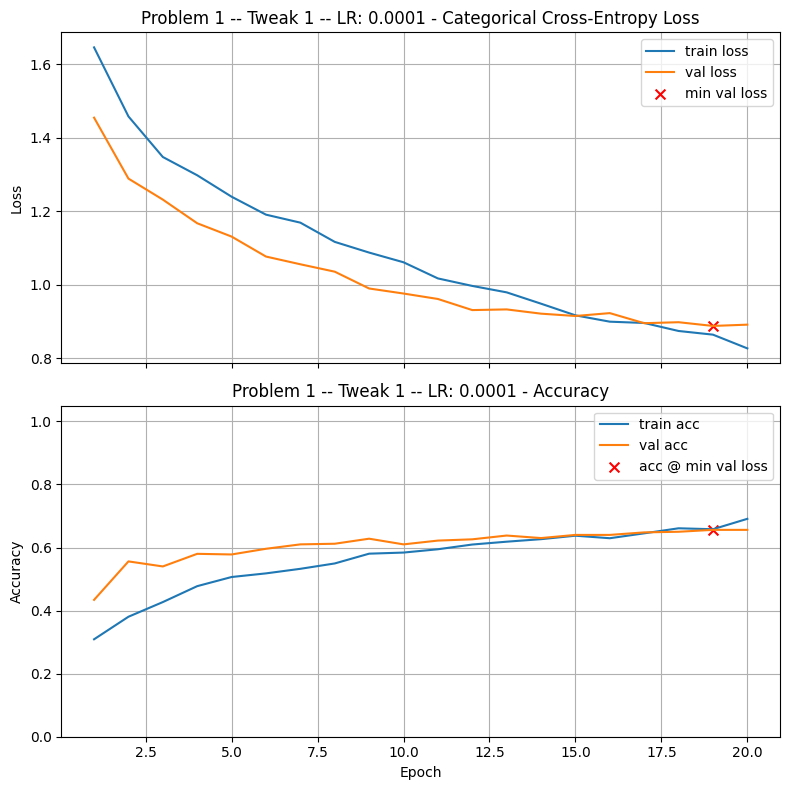

Final Training Loss:            0.8270
Final Training Accuracy:        0.6910
Final Validation Loss:          0.8915
Final Validation Accuracy:      0.6560
Minimum Validation Loss:        0.8880 (Epoch 19)
Validation Accuracy @ Min Loss: 0.6560

Test Loss: 0.8962
Test Accuracy: 0.6747

Validation-Test Gap (accuracy): 0.018667

Execution Time: 00:01:47

EXPERIMENT 2: Wider Model (32->64 filters instead of 16->32)

Problem 1 -- Tweak 2 -- Width: 32->64 filters



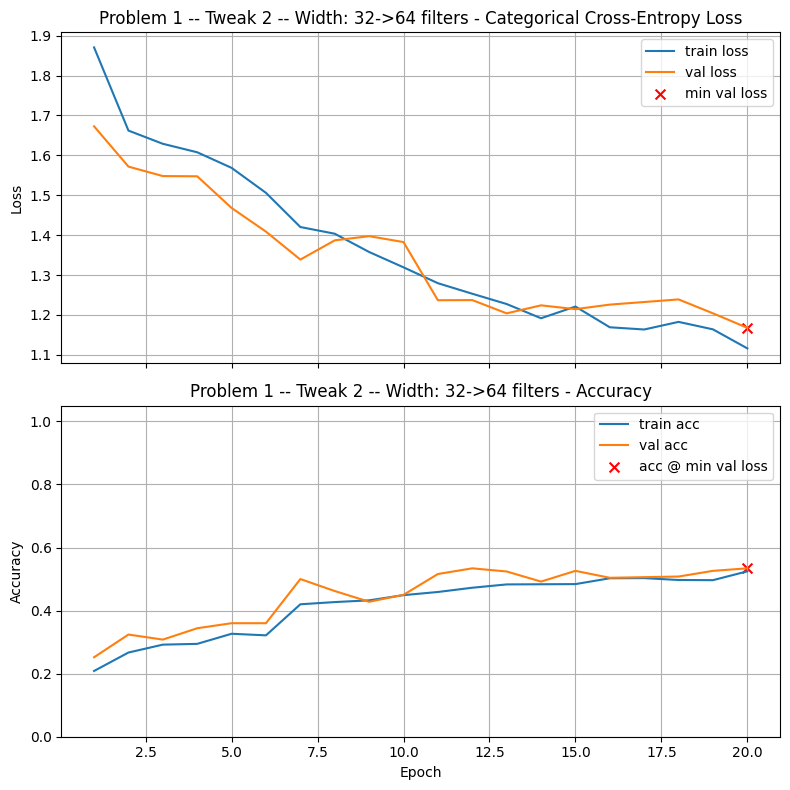

Final Training Loss:            1.1163
Final Training Accuracy:        0.5245
Final Validation Loss:          1.1678
Final Validation Accuracy:      0.5340
Minimum Validation Loss:        1.1678 (Epoch 20)
Validation Accuracy @ Min Loss: 0.5340

Test Loss: 1.1842
Test Accuracy: 0.5407

Validation-Test Gap (accuracy): 0.006667

Execution Time: 00:03:24

EXPERIMENT 3: Lower Dropout Rate (0.2 instead of 0.5)

Problem 1 -- Tweak 3 -- Dropout: 0.2



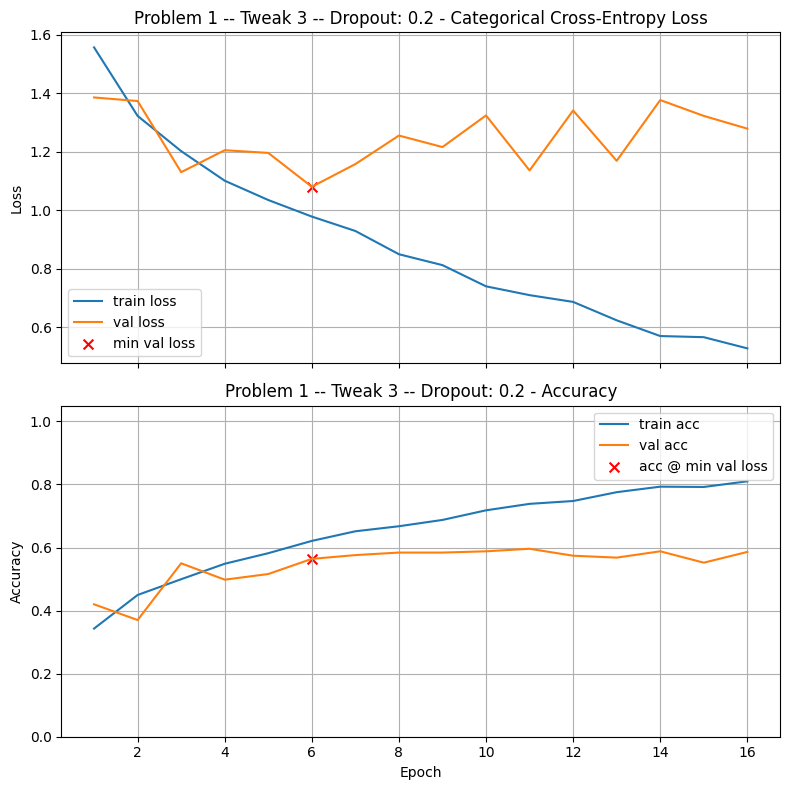

Final Training Loss:            0.5283
Final Training Accuracy:        0.8100
Final Validation Loss:          1.2789
Final Validation Accuracy:      0.5860
Minimum Validation Loss:        1.0805 (Epoch 6)
Validation Accuracy @ Min Loss: 0.5640

Test Loss: 1.0611
Test Accuracy: 0.5910

Validation-Test Gap (accuracy): 0.027000

Execution Time: 00:01:31

EXPERIMENT SUMMARY - Problem 1
Use print_results() to see all results ranked by validation accuracy
Problem 1 -- Tweak 1 -- LR: 0.0001      	0.6560	19
Conservative Baseline                   	0.6260	7
Problem 1 -- Tweak 3 -- Dropout: 0.2    	0.5640	6
Problem 1 -- Tweak 2 -- Width: 32->64 filters	0.5340	20
Baseline Model (Memory-Limited)         	0.1640	2


In [41]:
# Your code here, add additional cells if you wish

# Problem One: Exploring Basic Hyperparameters
# Testing 3 different hyperparameter tweaks to improve baseline performance

# Setup data subset function for consistent experiments
def setup_data_subset():
    """Setup consistent data subset for all experiments"""
    X_train_subset = X_train[:2000]
    y_train_subset = y_train[:2000]
    X_val_subset = X_val[:500]
    y_val_subset = y_val[:500]
    
    # Temporarily override globals
    global X_train_orig, y_train_orig, X_val_orig, y_val_orig
    X_train_orig, y_train_orig = X_train, y_train
    X_val_orig, y_val_orig = X_val, y_val
    
    return X_train_subset, y_train_subset, X_val_subset, y_val_subset

def restore_data():
    """Restore original data after experiment"""
    global X_train, y_train, X_val, y_val
    X_train, y_train = X_train_orig, y_train_orig
    X_val, y_val = X_val_orig, y_val_orig

# =============================================================================
# EXPERIMENT 1: Learning Rate Adjustment
# =============================================================================
print("="*60)
print("EXPERIMENT 1: Lower Learning Rate (1e-4 instead of 1e-3)")
print("="*60)

X_train_sub, y_train_sub, X_val_sub, y_val_sub = setup_data_subset()
X_train, y_train, X_val, y_val = X_train_sub, y_train_sub, X_val_sub, y_val_sub

he = initializers.HeNormal()
model_lr = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(16, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_lr, 
               title="Problem 1 -- Tweak 1 -- LR: 0.0001",
               lr_schedule=1e-4,  # Lower learning rate
               batch_size=16,
               epochs=20)

restore_data()

# =============================================================================
# EXPERIMENT 2: Increase Model Width (More Filters)
# =============================================================================
print("\n" + "="*60)
print("EXPERIMENT 2: Wider Model (32->64 filters instead of 16->32)")
print("="*60)

X_train_sub, y_train_sub, X_val_sub, y_val_sub = setup_data_subset()
X_train, y_train, X_val, y_val = X_train_sub, y_train_sub, X_val_sub, y_val_sub

he = initializers.HeNormal()
model_wide = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # 16->32
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # 32->64
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_wide, 
               title="Problem 1 -- Tweak 2 -- Width: 32->64 filters",
               batch_size=16,
               epochs=20)

restore_data()

# =============================================================================
# EXPERIMENT 3: Modify Dropout Rate
# =============================================================================
print("\n" + "="*60)
print("EXPERIMENT 3: Lower Dropout Rate (0.2 instead of 0.5)")
print("="*60)

X_train_sub, y_train_sub, X_val_sub, y_val_sub = setup_data_subset()
X_train, y_train, X_val, y_val = X_train_sub, y_train_sub, X_val_sub, y_val_sub

he = initializers.HeNormal()
model_dropout = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(16, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.2),  # Reduced from 0.5 to 0.2
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dropout, 
               title="Problem 1 -- Tweak 3 -- Dropout: 0.2",
               batch_size=16,
               epochs=20)

restore_data()

# =============================================================================
# SUMMARY OF EXPERIMENTS
# =============================================================================
print("\n" + "="*60)
print("EXPERIMENT SUMMARY - Problem 1")
print("="*60)
print("Use print_results() to see all results ranked by validation accuracy")
print_results()

### Graded Questions

In [42]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 1             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [43]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 1


In [44]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a. 

a1b = 0.6560             # Replace 0.0 with your answer

In [45]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.6560


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence. 

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer. 
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design. 
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.



EXPERIMENT 1: Best Model (LR=1e-4) + Batch Normalization

Problem 2 -- Best Model + BatchNorm



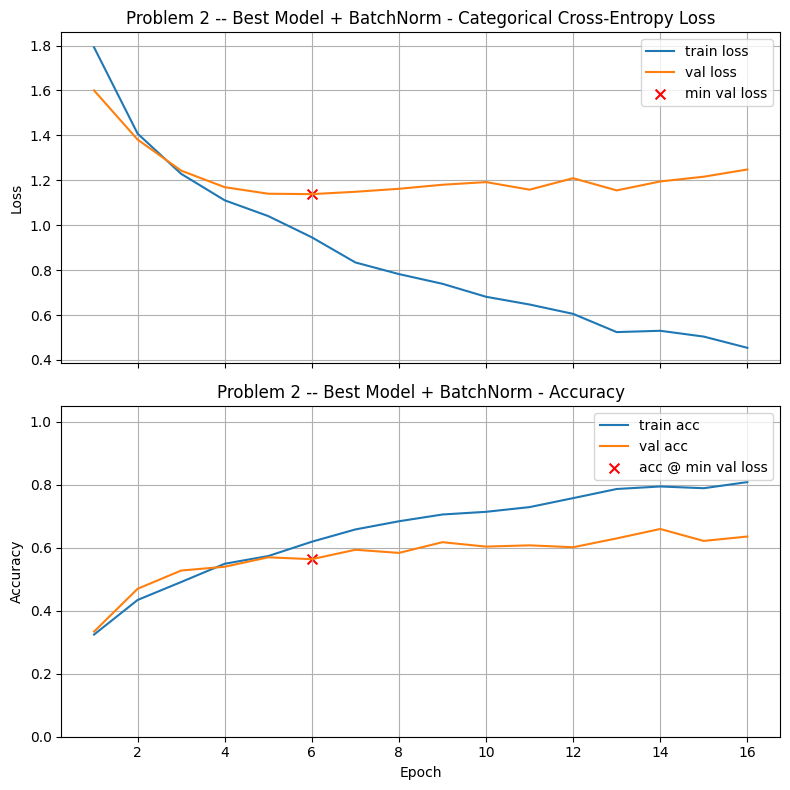

Final Training Loss:            0.4540
Final Training Accuracy:        0.8090
Final Validation Loss:          1.2481
Final Validation Accuracy:      0.6360
Minimum Validation Loss:        1.1383 (Epoch 6)
Validation Accuracy @ Min Loss: 0.5640

Test Loss: 1.1182
Test Accuracy: 0.5853

Validation-Test Gap (accuracy): 0.021333

Execution Time: 00:02:15

EXPERIMENT 2: BatchNorm + Lower Dropout Rate (0.2)

Problem 2 -- BatchNorm + Dropout 0.2



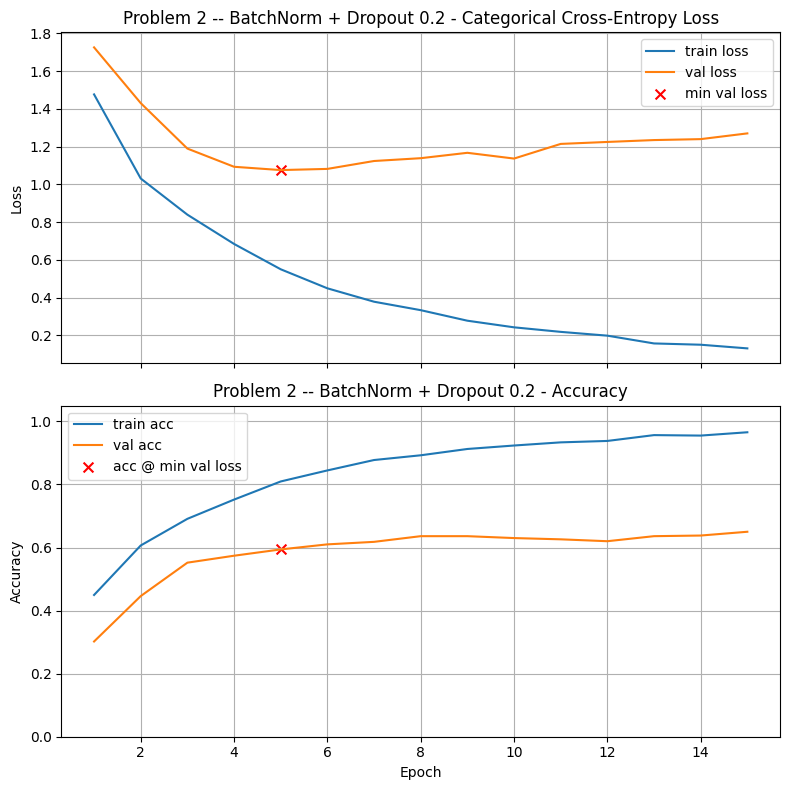

Final Training Loss:            0.1314
Final Training Accuracy:        0.9655
Final Validation Loss:          1.2706
Final Validation Accuracy:      0.6500
Minimum Validation Loss:        1.0762 (Epoch 5)
Validation Accuracy @ Min Loss: 0.5940

Test Loss: 1.0397
Test Accuracy: 0.6317

Validation-Test Gap (accuracy): 0.037667

Execution Time: 00:01:58

EXPERIMENT 3: BatchNorm + Wider Model (32->64 filters)

Problem 2 -- BatchNorm + Wide Model



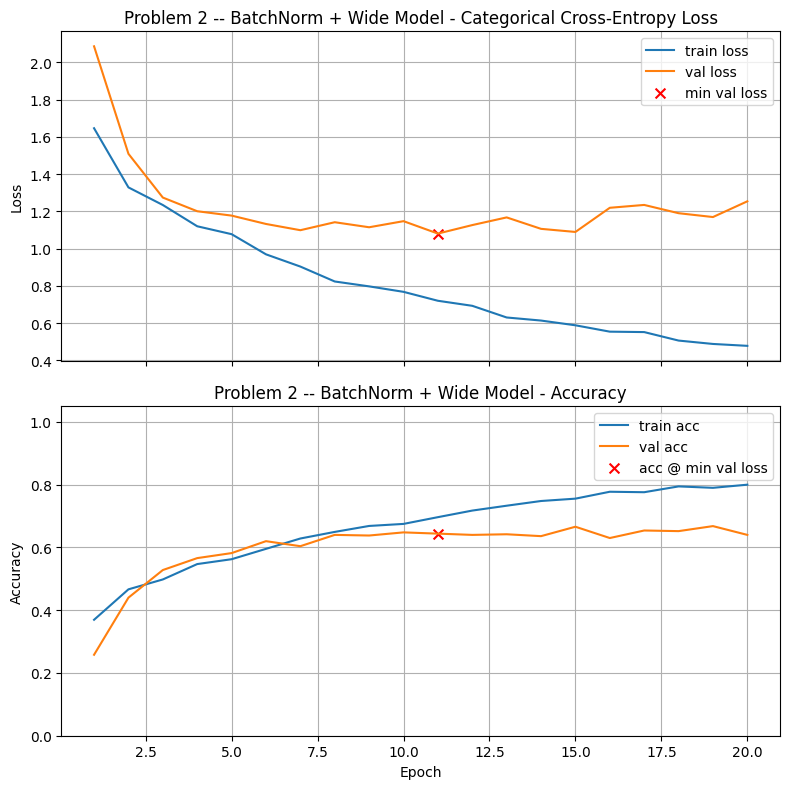

Final Training Loss:            0.4778
Final Training Accuracy:        0.8000
Final Validation Loss:          1.2536
Final Validation Accuracy:      0.6400
Minimum Validation Loss:        1.0804 (Epoch 11)
Validation Accuracy @ Min Loss: 0.6440

Test Loss: 1.0500
Test Accuracy: 0.6517

Validation-Test Gap (accuracy): 0.007667

Execution Time: 00:06:21

EXPERIMENT SUMMARY - Problem 2
Comparing BatchNormalization effects:
- Baseline (Problem 1 best): 65.6% validation accuracy
- With BatchNorm alone
- With BatchNorm + additional tweaks

Use print_results() to see all results ranked by validation accuracy
Problem 1 -- Tweak 1 -- LR: 0.0001      	0.6560	19
Problem 2 -- BatchNorm + Wide Model     	0.6440	11
Conservative Baseline                   	0.6260	7
Problem 2 -- BatchNorm + Dropout 0.2    	0.5940	5
Problem 1 -- Tweak 3 -- Dropout: 0.2    	0.5640	6
Problem 2 -- Best Model + BatchNorm     	0.5640	6
Problem 1 -- Tweak 2 -- Width: 32->64 filters	0.5340	20
Baseline Model (Memory-Limited)  

In [46]:
# Your code here, add additional cells if you wish

# Problem Two: Adding Batch Normalization
# Taking the best model from Problem 1 (lower learning rate) and adding BatchNormalization

def setup_data_subset():
    """Setup consistent data subset for all experiments"""
    X_train_subset = X_train[:2000]
    y_train_subset = y_train[:2000]
    X_val_subset = X_val[:500]
    y_val_subset = y_val[:500]
    
    # Temporarily override globals
    global X_train_orig, y_train_orig, X_val_orig, y_val_orig
    X_train_orig, y_train_orig = X_train, y_train
    X_val_orig, y_val_orig = X_val, y_val
    
    return X_train_subset, y_train_subset, X_val_subset, y_val_subset

def restore_data():
    """Restore original data after experiment"""
    global X_train, y_train, X_val, y_val
    X_train, y_train = X_train_orig, y_train_orig
    X_val, y_val = X_val_orig, y_val_orig

# =============================================================================
# EXPERIMENT 1: Best Model from Problem 1 + Batch Normalization
# =============================================================================
print("="*70)
print("EXPERIMENT 1: Best Model (LR=1e-4) + Batch Normalization")
print("="*70)

X_train_sub, y_train_sub, X_val_sub, y_val_sub = setup_data_subset()
X_train, y_train, X_val, y_val = X_train_sub, y_train_sub, X_val_sub, y_val_sub

he = initializers.HeNormal()
model_bn = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(16, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),  # Add BN after first Conv2D
    MaxPooling2D(2),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),  # Add BN after second Conv2D
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_bn, 
               title="Problem 2 -- Best Model + BatchNorm",
               lr_schedule=1e-4,  # Use the best LR from Problem 1
               batch_size=16,
               epochs=20)

restore_data()

# =============================================================================
# EXPERIMENT 2: BatchNorm + Additional Tweak (Lower Dropout)
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 2: BatchNorm + Lower Dropout Rate (0.2)")
print("="*70)

X_train_sub, y_train_sub, X_val_sub, y_val_sub = setup_data_subset()
X_train, y_train, X_val, y_val = X_train_sub, y_train_sub, X_val_sub, y_val_sub

he = initializers.HeNormal()
model_bn_dropout = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(16, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.2),  # Lower dropout combined with BatchNorm
    Dense(num_classes, activation="softmax")
])

train_and_test(model_bn_dropout, 
               title="Problem 2 -- BatchNorm + Dropout 0.2",
               lr_schedule=1e-4,
               batch_size=16,
               epochs=20)

restore_data()

# =============================================================================
# EXPERIMENT 3: BatchNorm + Wider Model
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 3: BatchNorm + Wider Model (32->64 filters)")
print("="*70)

X_train_sub, y_train_sub, X_val_sub, y_val_sub = setup_data_subset()
X_train, y_train, X_val, y_val = X_train_sub, y_train_sub, X_val_sub, y_val_sub

he = initializers.HeNormal()
model_bn_wide = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # Wider
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # Wider
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_bn_wide, 
               title="Problem 2 -- BatchNorm + Wide Model",
               lr_schedule=1e-4,
               batch_size=16,
               epochs=20)

restore_data()

# =============================================================================
# SUMMARY OF BATCH NORMALIZATION EXPERIMENTS
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT SUMMARY - Problem 2")
print("="*70)
print("Comparing BatchNormalization effects:")
print("- Baseline (Problem 1 best): 65.6% validation accuracy")
print("- With BatchNorm alone")
print("- With BatchNorm + additional tweaks")
print("\nUse print_results() to see all results ranked by validation accuracy")
print_results()

### Graded Questions

In [21]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = ...             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 


a2a = Ellipsis


In [23]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem) 

a2b = 0.0             # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.0000


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video, 
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique). 

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block. 

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design. 
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.



In [25]:
# Your code here, add additional cells if you wish



### Graded Questions

In [26]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = ...             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 


a3a = Ellipsis


In [28]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem) 

a3b = 0.0             # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.0000


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!). 
* Answer the graded questions.



In [30]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

### Graded Questions

In [31]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.0             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [32]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.2f}') 

a4a = 0.00


In [33]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem) 

a4b = 0.0             # Replace 0.0 with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.0000


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see:

        https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

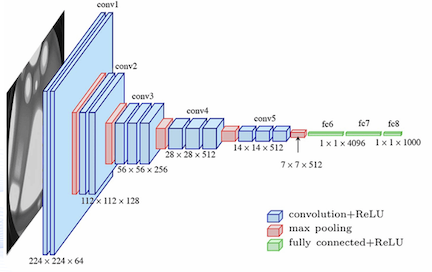


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss** 
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect. 



In [35]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

# train_and_test(model_vgg_16,lr_schedule=1e-3,title="VGG-style Large")


### Graded Questions

In [36]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 0.0             # Replace with your best learning rate

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.8f}') 

a5a = 0.00000000


In [38]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem) 

a5b = 0.0              # Replace 0.0 with your answer           

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.0000


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [40]:
print_results()

Conservative Baseline                   	0.6260	7
Baseline Model (Memory-Limited)         	0.1640	2
